In [1]:
"""
@inproceedings{
    manor2024posterior,
    title={On the Posterior Distribution in Denoising: Application to Uncertainty Quantification},
    author={Hila Manor and Tomer Michaeli},
    booktitle={The Twelfth International Conference on Learning Representations},
    year={2024},
    url={https://openreview.net/forum?id=adSGeugiuj}
}
"""
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import os
import subprocess # inkspace
from scipy.linalg import toeplitz
plt.rcParams["text.usetex"] = True
np.random.seed(20)
# import seaborn as sns
# sns.set_style('white')
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "cmu-serif",
    "mathtext.fontset": "cm",
    "font.size": 18
})

In [2]:
def sample_multivariate_gaussian_mixture(M: int, mus: np.array, sigmas: np.array, N: int = 10000, weights: np.array = None) -> np.array:
    """
    Sample data points from a Gaussian Mixture Model (GMM) using the Component Selection Method.
    
    This function first generates samples from all individual multivariate Gaussian distributions 
    and then selects one component per data point based on the given mixture weights.

    Sampling process:
    1. Generate an array of shape (N, d, M), where each column represents samples drawn from 
       a different Gaussian component.
    2. Randomly select one component for each data point according to the specified `weights`.
    3. Return the selected samples, ensuring that the final output has the shape (N, d).

    Parameters:
        M (int): Number of Gaussian components in the mixture.
        mus (list of np.array): List of mean vectors for each Gaussian component, 
                                where each element is a (d,) numpy array.
        sigmas (list of np.array): List of covariance matrices for each Gaussian component, 
                                   where each element is a (d, d) numpy array.
        N (int): Number of data points to sample.
        weights (list or np.array, optional): Probability weights for selecting each Gaussian 
                                              component. If None, all components are assumed 
                                              to be equally weighted (1/M).

    Returns:
        np.array: An array of shape (N, d), where each row is a sampled data point.
    """

    assert (M == len(mus))
    
    samples = np.zeros((N, len(mus[0]), M), dtype=np.float64)
    for i in range(M):
        samples[:, :, i] = np.random.multivariate_normal(mus[i], sigmas[i], size=(N,)).astype(np.float64)

    if weights is None:
        weights = np.ones(M, dtype=np.float64) / M
    random_idx = np.random.choice(np.arange(M), size=(N,), p=weights)
    return samples[np.arange(N), :, random_idx]


def mu1_real(y: np.array ,A: np.array, sigma1: np.array, sigma2: np.array, Nsigma: np.array, m1: np.array, m2: np.array) -> np.array:
    """
    Calculates the theoretical posterior E(x|y) of a two-component GMM with transformation y = Ax + e.
    Parameters:
        y: np.array(d, N)         - Observations (d-dimensional, N samples)
        sigma1: np.array(d, d)    - Covariance matrix of the first Gaussian component
        sigma2: np.array(d, d)    - Covariance matrix of the second Gaussian component
        Nsigma: np.array(d, d)    - Covariance matrix of noise (diagonal elements)
        m1, m2: np.array(d, 1)    - Mean vectors of the Gaussian components
        A: np.array(d, d)         - Transformation matrix in y = Ax + e
    Returns:
        E[x | y]: np.array(d, N)  - Posterior expected value of x given y
    """
    y = y.astype(np.float64)

    inv_term1 = np.linalg.inv(A @ sigma1 @ A.T + Nsigma)
    inv_term2 = np.linalg.inv(A @ sigma2 @ A.T + Nsigma)

    mu1 = m1 + sigma1 @ A.T @ inv_term1 @ (y - A @ m1)
    mu2 = m2 + sigma2 @ A.T @ inv_term2 @ (y - A @ m2)

    p1 = np.exp(-0.5 * np.diag((y - A @ m1).T @ inv_term1 @ (y - A @ m1)))
    p2 = np.exp(-0.5 * np.diag((y - A @ m2).T @ inv_term2 @ (y - A @ m2)))

    return (mu1 * p1 + mu2 * p2) / (p1 + p2)


def px_pdf_real(xs, sigma1, sigma2, m1, m2):
    # Calculate the pdf of a wo-component Gaussian Mixture Model (GMM)
    xs = xs.astype(np.float64)
    norm_const1 = 1 / (2* np.pi * np.linalg.det(sigma1))
    norm_const2 = 1 / (2* np.pi * np.linalg.det(sigma2))
    pdf1 = norm_const1 * np.diag(np.exp(-0.5 * (xs - m1).T @ np.linalg.inv((sigma1)) @ (xs - m1)))
    pdf2 = norm_const2 * np.diag(np.exp(-0.5 * (xs - m2).T @ np.linalg.inv((sigma2)) @ (xs - m2)))
    return 0.5 * pdf1 + 0.5 * pdf2



In [3]:
# GMM sampling
mus = [np.array([1, 2]), np.array([8, 10])]
sigmas = [np.array([[1, 0], [0, 2]]), np.array([[2, 1], [1, 1]])]
sigma1, sigma2 = sigmas
m1, m2 = mus
m1, m2 = m1.reshape(2,1), m2.reshape(2,1)
x = sample_multivariate_gaussian_mixture(2, mus, sigmas, weights=np.array([0.5, 0.5])).astype(np.float64)
x = x.T 
# Generate a random linear Transformation
A = np.random.randn(2, 2)
print(np.linalg.det(A) == 0) # check the singularity of A

# Generagte noise

noise_sigma2 = 2
Nsigma = noise_sigma2 * np.eye(2)
n = np.random.multivariate_normal(np.array([0, 0]), Nsigma, (len(x.T),)).astype(np.float64).T

# create y
y = A @ x + n



False


In [4]:
def compute_snr(A, x, n):
    """
    Compute Signal-to-Noise Ratio (SNR)
    params: 
        A: Transformation matrix (2,2)
        x: Original signal (2, N)
        n: Noise (2, N)
    Returns:
        SNR (dB)
    """
    Ax = A @ x  # Transformed signal
    signal_power = np.mean(np.linalg.norm(Ax, axis=0) ** 2)  # Compute signal power
    noise_power = np.mean(np.linalg.norm(n, axis=0) ** 2)  # Compute noise power
    snr_db = 10 * np.log10(signal_power / noise_power)  # Convert to dB
    return snr_db

snr_value = compute_snr(A, x, n)
print(f"SNR (dB): {snr_value:.2f}")

SNR (dB): 7.91


In [5]:
train_samples_x = x[:, :int(x.shape[-1] * 0.8)]
test_samples_x  = x[:, int(x.shape[-1] * 0.8):]
train_samples_y = y[:, :int(y.shape[-1] * 0.8)]
test_samples_y  = y[:, int(y.shape[-1] * 0.8):]

In [6]:
print(test_samples_y.shape)

(2, 2000)


Text(0.5, 1.0, '$p(x)$ vs $p(x|y)$')

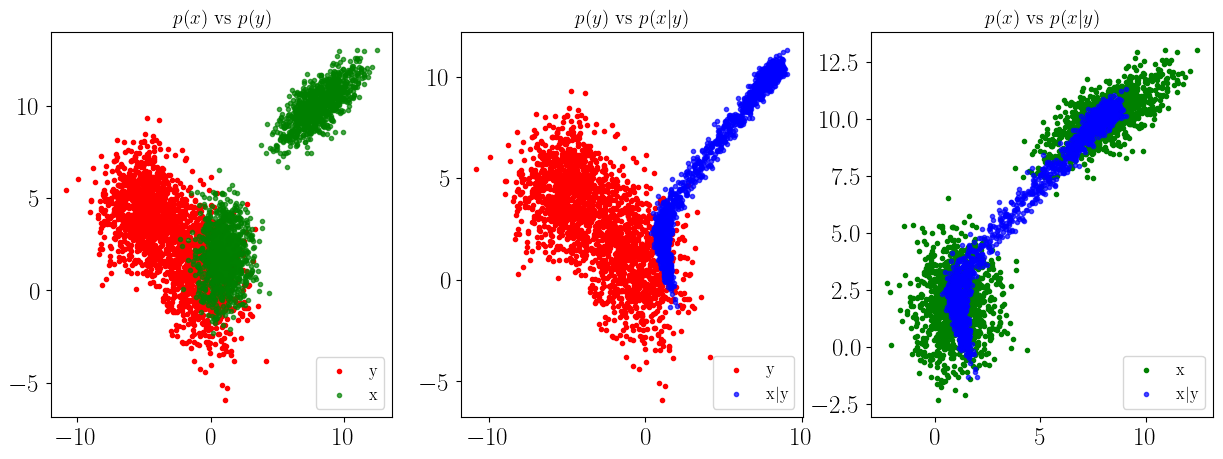

In [7]:

%matplotlib inline
mu1_real_res = mu1_real(test_samples_y, A, sigma1, sigma2, Nsigma, m1, m2)

plt.figure(figsize=(15,5))
plt.subplot(1, 3, 1)
plt.scatter(test_samples_y[0], test_samples_y[1], marker='.', color='red', alpha=1, label='y')
# sns.scatterplot(test_samples_y, marker='.', color='red', alpha=1, label='y')
plt.scatter(test_samples_x[0], test_samples_x[1], marker='.', color='green', alpha=0.7, label='x')
plt.legend(loc='lower right', fontsize=12)
plt.title('$p(x)$ vs $p(y)$', fontsize=14)

plt.subplot(1, 3, 2)
plt.scatter(test_samples_y[0], test_samples_y[1], marker='.', color='red', alpha=1, label='y')
plt.scatter(mu1_real_res[0], mu1_real_res[1], marker='.', color='blue', alpha=0.7, label='x$|$y')
plt.legend(loc='lower right', fontsize=12)
plt.title('$p(y)$ vs $p(x|y)$', fontsize=14)

plt.subplot(1, 3, 3)
plt.scatter(test_samples_x[0], test_samples_x[1], marker='.', color='green', alpha=1, label='x')
plt.scatter(mu1_real_res[0], mu1_real_res[1], marker='.', color='blue', alpha=0.7, label='x$|$y')
plt.legend(loc='lower right', fontsize=12)
plt.title('$p(x)$ vs $p(x|y)$', fontsize=14)

In [8]:
x_1 = np.array([4.5, 5]).reshape(2,1).astype(np.float64)
y_1 = A @ x_1 + np.random.multivariate_normal(np.array([0,0]), Nsigma, (1,)).reshape(2,1).astype(np.float64)
# y_1 = np.array([[3.5], [6.35]]).astype(np.float64)

In [9]:
iters = 500
n_ev = 2
c = 1e-5

custom_ev = None

A_invT = np.linalg.inv(A.T)
mmse = mu1_real(y_1, A, sigma1, sigma2, Nsigma, m1, m2)
bmmse = np.concatenate([mmse] * n_ev, axis=1)
eigvecs = np.random.randn(*bmmse.shape).astype(np.float64)
if custom_ev is None:
    for i in range(iters):
        out = mu1_real(y_1 + eigvecs, A, sigma1, sigma2, Nsigma, m1, m2)
        Ab = (out - mmse)
        Ab = Ab @ A_invT
        if n_ev > 1:
            norm_of_Ab = np.linalg.norm(Ab.astype(np.float64), axis=0).astype(np.float64)
            eigvecs = Ab / norm_of_Ab  # Complete the power iteration
            
            # Make sure the evs are orthonormal
            Q = np.linalg.qr(eigvecs.astype(np.float64), mode='reduced')[0].astype(np.float64)
            eigvecs = Q / np.linalg.norm(Q.astype(np.float64), axis=0).astype(np.float64)
        else:
            norm_of_Ab = np.linalg.norm(Ab.astype(np.float64).ravel()).astype(np.float64)
            eigvecs = Ab / norm_of_Ab # This completes the power iteration
        eigvecs *= c
    eigvals = (norm_of_Ab / c * noise_sigma2).reshape(n_ev, )
    eigvals /= np.linalg.norm(A_invT, ord=2)
    eigvecs /= c
else:
    eigvecs = custom_ev
    out = mu1_real(y_1 + eigvecs * c, A, sigma1, sigma2, Nsigma, m1, m2)
    Ab = (out - mmse)
    Ab = Ab @ A_invT
    eigvals = np.linalg.norm(Ab.astype(np.float64), axis=0).astype(np.float64) / c * noise_sigma2
    eigvals /= np.linalg.norm(A_invT, ord=2)
first_moments = eigvecs.T @ mmse
second_moments = eigvals

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


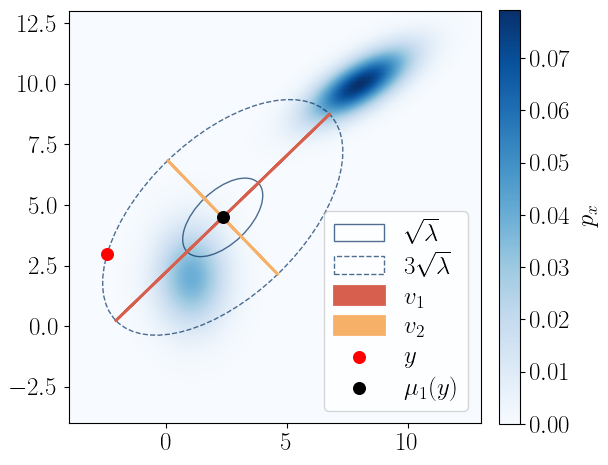

In [10]:

plt.figure(figsize=(6,5))
# plt.scatter(test_samples_y[0], test_samples_y[1], marker='.', color='#fe94d0', alpha=0.6, label='samples from $p_y$', s=5)
# plt.scatter(test_samples_x[0], test_samples_x[1], marker='.', color='#74add1', alpha=1, label='samples from $p_x$', s=5)
[XX, YY] = np.meshgrid(np.linspace(-4,13, 100), np.linspace(-4,13, 100))
xs = np.stack([XX.ravel(), YY.ravel()])

c = plt.imshow(px_pdf_real(xs, sigma1, sigma2, m1, m2).reshape(XX.shape), cmap='Blues', origin='lower', extent=[-4, 13, -4, 13], interpolation='bilinear')

angle = np.arctan2(eigvecs[1,0], eigvecs[0,0]) * 180 / np.pi
ellipse = patches.Ellipse((mmse[0,0], mmse[1,0]), 2 * np.sqrt(eigvals[0]), 2 * np.sqrt(eigvals[1]), angle=angle,
                          fill=False, alpha=0.7, edgecolor='#053061', label='$\sqrt{\lambda}$')
plt.gca().add_artist(ellipse)

threesig_ellipse = patches.Ellipse((mmse[0,0], mmse[1,0]), 6 * np.sqrt(eigvals[0]), 6 * np.sqrt(eigvals[1]), angle=angle,
                          fill=False, alpha=0.7, edgecolor='#053061', linestyle='--', label='$3\sqrt{\lambda}$')
plt.gca().add_artist(threesig_ellipse)

plt.arrow(mmse[0,0], mmse[1,0], eigvecs[0,0] * 3 * np.sqrt(eigvals[0]), eigvecs[1,0] * 3 * np.sqrt(eigvals[0]), head_length=0, color='#d6604d', linewidth=2, label='$v_1$')
plt.arrow(mmse[0,0], mmse[1,0], -eigvecs[0,0] * 3 * np.sqrt(eigvals[0]), -eigvecs[1,0] * 3 * np.sqrt(eigvals[0]), head_length=0, color='#d6604d', linewidth=2)
if n_ev > 1:
    plt.arrow(mmse[0,0], mmse[1,0], eigvecs[0,1] * 3 * np.sqrt(eigvals[1]), eigvecs[1,1] * 3 * np.sqrt(eigvals[1]), head_length=0, color='#f7b068', linewidth=2, label='$v_2$')
    plt.arrow(mmse[0,0], mmse[1,0], -eigvecs[0,1] * 3 * np.sqrt(eigvals[1]), -eigvecs[1,1] * 3 * np.sqrt(eigvals[1]), head_length=0, color='#f7b068', linewidth=2)
plt.scatter(y_1[0], y_1[1], marker='o', color='red', label='$y$', s=70)
plt.scatter(mmse[0], mmse[1], marker='o', color='black', label='$\mu_1(y)$', s=70)

y_up = (mmse + 3 * np.sqrt(eigvals) * eigvecs)[:,0]
y_down = (mmse - 3 * np.sqrt(eigvals) * eigvecs)[:, 0]

# plt.scatter(y_up[0], y_up[1], marker='+', color='black', label='$\mu_1(y) +3\sqrt{\lambda} v$', s=70)
# plt.scatter(y_down[0], y_down[1], marker='*', color='black', label='$\mu_1(y) -3 \sqrt{\lambda} v$', s=70)
# plt.gca().axis([test_samples_y.min(), test_samples_y.max(), test_samples_y.min(), test_samples_y.max()])
plt.colorbar(c, ax=plt.gca(), label="$p_x$", fraction=0.046, pad=0.04)

# plt.colorbar()
# plt.clabel('$p_x$')
plt.legend(loc='lower right', labelspacing=0.3)
plt.tight_layout()
ylimmin, ylimmax = plt.gca().get_ylim()
xlimmin, xlimmax = plt.gca().get_xlim()
os.makedirs('Figures', exist_ok=True)
plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.pdf'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.png'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.svg'), dpi=500, bbox_inches='tight')
plt.savefig(os.path.join('Figures', 'GMM_Example_theoretical.eps'), dpi=500, bbox_inches='tight')
subprocess.call('inkscape Figures/GMM_Example_theoretical.svg --export-type="emf"',shell=True)

plt.show()

In [11]:
print(xs.shape)

(2, 10000)


# real derivatives

In [22]:
h=1e-5
third_moments = []
fourth_moments = []
for i in range(n_ev):
    first_term = mu1_real(y_1 + eigvecs[:, i].reshape(2,1) * 2 * h, A, sigma1, sigma2, Nsigma, m1, m2)
    second_term = mu1_real(y_1 + eigvecs[:, i].reshape(2,1) * h, A, sigma1, sigma2, Nsigma, m1, m2)
    third_term = mu1_real(y_1, A, sigma1, sigma2, Nsigma, m1, m2)
    fourth_term = mu1_real(y_1 - eigvecs[:, i].reshape(2,1) * h, A, sigma1, sigma2, Nsigma, m1, m2)
    deriv_approx = (1/(h**3)) * (first_term - 3 * second_term + 3 * third_term - fourth_term)

    fourth_moments.append((noise_sigma2 ** 3) * (eigvecs[:, i] @ deriv_approx)[0] + 3 * (second_moments[i] ** 2))

    deriv_approx = (1/(h**2)) * (second_term - 2 * third_term + fourth_term)
    third_moments.append((noise_sigma2 ** 2) * (eigvecs[:, i] @ deriv_approx)[0])

print(f'vmu1 = {first_moments[:,0]};')
print(f'vmu2 = {second_moments};')
print(f'vmu3 = {third_moments};')
print(f'vmu4 = {fourth_moments};')
print(f'noisy_sample = [{y_1[0,0]}; {y_1[1,0]}];')
print(f'mmse_sample = [{mmse[0,0]}; {mmse[1,0]}];')
print(f'real_sample = [{x_1[0,0]} {x_1[1,0]}];')
print(f'evs = {eigvecs};')

vmu1 = [-4.80811566  1.59225377];
vmu2 = [4.16743323 1.18120077];
vmu3 = [-0.9862647632030825, -0.8931490629697834];
vmu4 = [61.97593436401914, 1.7173469900263765];
noisy_sample = [-2.4111022021739688; 2.968061046130689];
mmse_sample = [2.3518303465387955; 4.485771091707819];
real_sample = [4.5 5.0];
evs = [[-0.71922113 -0.69478123]
 [-0.69478123  0.71922113]];


d1_x[0]: -1.7888681220091462
d1_x[0]: 0.5052230069733438
vmu1 = [-4.80811566  1.59225377];
vmu2 = [4.16743323 1.18120077];
vmu3 = [-0.9862466052934711, -0.8931973008908514];
vmu4 = [9.603103066491823, -0.4863990366674682];
noisy_sample = [-2.4111022021739688; 2.968061046130689];
mmse_sample = [2.3518303465387955; 4.485771091707819];
real_sample = [4.5 5.0];
evs = [[-0.71922113 -0.69478123]
 [-0.69478123  0.71922113]];


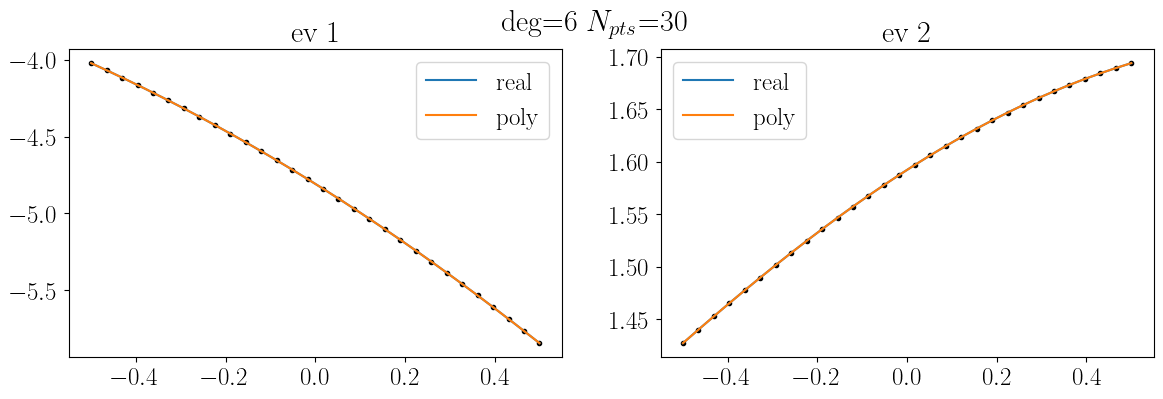

In [23]:
# x: sqrt(second_moments), i.e. lambda/eigenvalues of the second moment matrix
# y: v^T E(x|y)
%notebook inline

def poly(xs, coeffs):
    deg = len(coeffs) -1
    
    value = np.zeros_like(xs, dtype=xs.dtype)
    for d in range(len(coeffs)):
        value += coeffs[d] * (xs ** (deg - d))
    return value

def d1_dx_poly(xs, coeffs):
    deg = len(coeffs) - 1
    
    value = np.zeros_like(xs, dtype=xs.dtype)
    for i in range(deg):
        value += (deg - i) * coeffs[i] * (xs ** (deg - 1 - i))
    return value

def d2_dx_poly(xs, coeffs):
    deg = len(coeffs) - 1
    
    value = np.zeros_like(xs, dtype=xs.dtype)
    for i in range(deg - 1):
        value += (deg - i) * (deg - 1 - i) * coeffs[i] * (xs ** (deg - 2 - i))
    return value
    
def d3_dx_poly(xs, coeffs):
    deg = len(coeffs) - 1
    
    value = np.zeros_like(xs, dtype=xs.dtype)
    for i in range(deg - 2):
        value += (deg - i) * (deg - 1 - i) * (deg - 2 - i) * coeffs[i] * (xs ** (deg - 3 - i))
    return value


deg = 6
delta = 30
fromto = 0.5
third_moments = []
fourth_moments = []
plt.figure(figsize=(7*n_ev, 4))
for i in range(n_ev):
    poly_xs = np.linspace(-fromto, fromto,delta) * np.sqrt(second_moments[i])
    poly_ys = eigvecs[:, i] @ mu1_real(y_1 + poly_xs * eigvecs[:, i].reshape(2,1),  A, sigma1, sigma2, Nsigma, m1, m2)

    coeffs = np.polyfit(poly_xs.astype(np.float64), poly_ys.astype(np.float64), deg=deg)

    plt.subplot(1, n_ev, i + 1)
    plt.plot(np.linspace(-fromto, fromto,delta), poly_ys, 'k.')
    poly_more_xs = np.linspace(-fromto, fromto, delta * 10) * np.sqrt(second_moments[i])
    
    realf = eigvecs[:, i] @ mu1_real(y_1 + poly_more_xs * eigvecs[:, i].reshape(2,1),  A, sigma1, sigma2, Nsigma, m1, m2)
    plt.plot(np.linspace(-fromto, fromto,delta*10), realf, label="real")
    plt.plot(np.linspace(-fromto, fromto,delta*10), poly(poly_more_xs, coeffs), label="poly")
    plt.legend()
    plt.title(f'ev {i+1}')
    
    d1_dx = noise_sigma2 * d1_dx_poly(np.array([0], dtype=y_1.dtype), coeffs)
    print(f'd1_x[0]: {d1_dx[0]}')
    d2_dx = d2_dx_poly(np.array([0], dtype=y_1.dtype), coeffs)
    d3_dx = d3_dx_poly(np.array([0], dtype=y_1.dtype), coeffs)
    third_moments.append((noise_sigma2 ** 2) * (d2_dx)[0])
    # fourth_moments.append((noise_sigma2 ** 3) * d3_dx[0] + 3 * (second_moments[i] ** 2))
    fourth_moments.append((noise_sigma2 ** 3) * d3_dx[0] + 3 * (d1_dx[0] ** 2))

plt.suptitle(f'deg={deg} $N_{{pts}}$={delta}')
#     first_term = mu1_real(y_1 + eigvecs[:, i].reshape(2,1) * 2 * h, sigma1, sigma2, Nsigma, m1, m2)
#     second_term = mu1_real(y_1 + eigvecs[:, i].reshape(2,1) * h, sigma1, sigma2, Nsigma, m1, m2)
#     third_term = mu1_real(y_1, sigma1, sigma2, Nsigma, m1, m2)
#     fourth_term = mu1_real(y_1 - eigvecs[:, i].reshape(2,1) * h, sigma1, sigma2, Nsigma, m1, m2)
#     deriv_approx = (1/(h**3)) * (first_term - 3 * second_term + 3 * third_term - fourth_term)

#     fourth_moments.append((noise_sigma2 ** 3) * (eigvecs[:, i] @ deriv_approx)[0] + 3 * (second_moments[i] ** 2))

#     deriv_approx = (1/(h**2)) * (second_term - 2 * third_term + fourth_term)
#     third_moments.append((noise_sigma2 ** 2) * (eigvecs[:, i] @ deriv_approx)[0])

print(f'vmu1 = {first_moments[:,0]};')
print(f'vmu2 = {second_moments};')
print(f'vmu3 = {third_moments};')
print(f'vmu4 = {fourth_moments};')
print(f'noisy_sample = [{y_1[0,0]}; {y_1[1,0]}];')
print(f'mmse_sample = [{mmse[0,0]}; {mmse[1,0]}];')
print(f'real_sample = [{x_1[0,0]} {x_1[1,0]}];')
print(f'evs = {eigvecs};')

vmu1 = [-4.80811566  1.59225377];
vmu2 = [4.16743323 1.18120077];
vmu3 = [-4.110216877961648, -1.0554644269689106];
vmu4 = [52.16644802469243, 2.6900133276376463];
noisy_sample = [-2.4111022021739688; 2.968061046130689];
mmse_sample = [2.3518303465387955; 4.485771091707819];
real_sample = [4.5 5.0];
evs = [[-0.71922113 -0.69478123]
 [-0.69478123  0.71922113]];


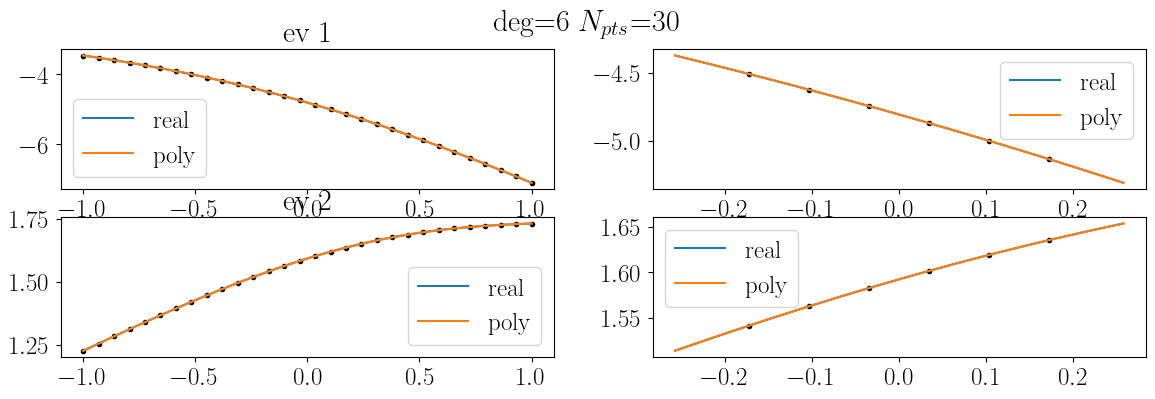

In [24]:
%notebook inline

def poly(xs, coeffs):
    deg = len(coeffs) -1
    
    value = np.zeros_like(xs, dtype=xs.dtype)
    for d in range(len(coeffs)):
        value += coeffs[d] * (xs ** (deg - d))
    return value

def d1_dx_poly(xs, coeffs):
    deg = len(coeffs) - 1
    
    value = np.zeros_like(xs, dtype=xs.dtype)
    for i in range(deg):
        value += (deg - i) * coeffs[i] * (xs ** (deg - 1 - i))
    return value

def d2_dx_poly(xs, coeffs):
    deg = len(coeffs) - 1
    
    value = np.zeros_like(xs, dtype=xs.dtype)
    for i in range(deg - 1):
        value += (deg - i) * (deg - 1 - i) * coeffs[i] * (xs ** (deg - 2 - i))
    return value
    
def d3_dx_poly(xs, coeffs):
    deg = len(coeffs) - 1
    
    value = np.zeros_like(xs, dtype=xs.dtype)
    for i in range(deg - 2):
        value += (deg - i) * (deg - 1 - i) * (deg - 2 - i) * coeffs[i] * (xs ** (deg - 3 - i))
    return value


deg = 6
delta = 30
fromto = 1

h=1e-4
third_moments = []
fourth_moments = []
plt.figure(figsize=(7*n_ev, 4))
for i in range(n_ev):
    poly_xs = np.linspace(-fromto, fromto,delta) * np.sqrt(second_moments[i])
    poly_ys = eigvecs[:, i] @ mu1_real(y_1 + poly_xs * eigvecs[:, i].reshape(2,1), A, sigma1, sigma2, Nsigma, m1, m2)

    coeffs = np.polyfit(poly_xs.astype(np.float64), poly_ys.astype(np.float64), deg=deg)

    plt.subplot(2, n_ev, 2*i + 1)
    plt.plot(np.linspace(-fromto, fromto,delta), poly_ys, 'k.')
    poly_more_xs = np.linspace(-fromto, fromto, delta * 10) * np.sqrt(second_moments[i])
    
    realf = eigvecs[:, i] @ mu1_real(y_1 + poly_more_xs * eigvecs[:, i].reshape(2,1), A, sigma1, sigma2, Nsigma, m1, m2)
    plt.plot(np.linspace(-fromto, fromto,delta*10), realf, label="real")
    plt.plot(np.linspace(-fromto, fromto,delta*10), poly(poly_more_xs, coeffs), label="poly")
    plt.legend()
    plt.title(f'ev {i+1}')

    plt.subplot(2, n_ev, 2*i + 2)
    graph_len = len(np.linspace(-fromto, fromto,delta)) //5 * 2
    plt.plot(np.linspace(-fromto, fromto,delta)[graph_len:-graph_len], poly_ys[graph_len:-graph_len], 'k.')
    graph_len = len(np.linspace(-fromto, fromto,delta*10)) // 8 *3
    plt.plot(np.linspace(-fromto, fromto,delta*10)[graph_len:-graph_len], realf[graph_len:-graph_len], label="real")
    plt.plot(np.linspace(-fromto, fromto,delta*10)[graph_len:-graph_len], poly(poly_more_xs, coeffs)[graph_len:-graph_len], label="poly")
    plt.legend()

    first_term = poly(np.array([2 * h], dtype=y_1.dtype)* np.sqrt(second_moments[i]), coeffs)
    second_term = poly(np.array([h], dtype=y_1.dtype)* np.sqrt(second_moments[i]), coeffs)
    third_term = poly(np.array([0], dtype=y_1.dtype), coeffs)
    fourth_term = poly(np.array([- h], dtype=y_1.dtype)* np.sqrt(second_moments[i]), coeffs)
    deriv_approx = (1/(h**3)) * (first_term - 3 * second_term + 3 * third_term - fourth_term)

    fourth_moments.append((noise_sigma2 ** 3) * (deriv_approx[0]) + 3 * (second_moments[i] ** 2))

    deriv_approx = (1/(h**2)) * (second_term - 2 * third_term + fourth_term)
    third_moments.append((noise_sigma2 ** 2) * (deriv_approx[0]))



plt.suptitle(f'deg={deg} $N_{{pts}}$={delta}')
#     first_term = mu1_real(y_1 + eigvecs[:, i].reshape(2,1) * 2 * h, sigma1, sigma2, Nsigma, m1, m2)
#     second_term = mu1_real(y_1 + eigvecs[:, i].reshape(2,1) * h, sigma1, sigma2, Nsigma, m1, m2)
#     third_term = mu1_real(y_1, sigma1, sigma2, Nsigma, m1, m2)
#     fourth_term = mu1_real(y_1 - eigvecs[:, i].reshape(2,1) * h, sigma1, sigma2, Nsigma, m1, m2)
#     deriv_approx = (1/(h**3)) * (first_term - 3 * second_term + 3 * third_term - fourth_term)

#     fourth_moments.append((noise_sigma2 ** 3) * (eigvecs[:, i] @ deriv_approx)[0] + 3 * (second_moments[i] ** 2))

#     deriv_approx = (1/(h**2)) * (second_term - 2 * third_term + fourth_term)
#     third_moments.append((noise_sigma2 ** 2) * (eigvecs[:, i] @ deriv_approx)[0])

print(f'vmu1 = {first_moments[:,0]};')
print(f'vmu2 = {second_moments};')
print(f'vmu3 = {third_moments};')
print(f'vmu4 = {fourth_moments};')
print(f'noisy_sample = [{y_1[0,0]}; {y_1[1,0]}];')
print(f'mmse_sample = [{mmse[0,0]}; {mmse[1,0]}];')
print(f'real_sample = [{x_1[0,0]} {x_1[1,0]}];')
print(f'evs = {eigvecs};')